# Topic Modelling applied to ancient vessels 

In this notebook, we analyse the datasets using topic modelling methods to infer and extract characteristical set of techniques of cultural pottery making. 


# Theory

A simple first analysis to addressing the problem of vessel reconstruction and inferring the transmitted knowledge of different populations could be the application of Latent Dirichlet allocation (LDA) model.
This model is a generative statistical model that is mainly used for topic modelling in natural language processing. The main purpose is the identification of abstract topics within a collection of documents. To apply this framework to our archaeological data we made the following parallelism: the documents are now the full chain-operatorie of the vessels, the words are a set of techniques, and initially, we set the topics to 2; the cultures involved in the study. 
First we will infer the parameters of the Dirichlet distribution of words in topics. Then we will relax the enforced number of topics and try to infer the most likely number of topics, leading to possible conclusion and knowledge contamination beyond the strict contact of the two considered culture. 

One of the core assumption of LDA is that documents (vessels) and words in that documents are interchangeable or independent (bag of words assumption). If we consider the plain chain operatorie this is obviously not true because one working step depends on the previous one; we cannot interchange the order of drying and modelling, the clay state is different and cannot be exchanged. Therefore, we might overcome this problem by considering a set of techniques as ``word'' in the document (vessel), i.e. using bi-grams or trigrams. In this frameworks, we might say that reasonably a trademark for a culture is a sequence of techniques, and thus, we en-lighten where this set of techniques is most pronounced or expressed in a particular topic (or culture, to use this parallelism). 

Let the data $\mathcal{W}=\left(\mathbf{w}^{(d)}\right)_{d=1}^D$, with $\mathbf{w}^{(d)}=\left(w_i^{(d)}\right)_{i=1}^{n_d}$ be a dataset of $D$ documents (vessels), consisting in vectors of words, whose components, the words (set of techniques) $w_i^{(d)}$, using a categorical can be mapped as natural numbers from 1 to the dictionary size $W$. In the generative model likelihood, the documents are independent, and the probability of a vector of words $\mathbf{w}^{(d)}$ within a document is independent of the order of the vector elements (the so called bag of word assumption):

$$
P(\mathcal{W})=\prod_{d=1}^D \prod_{i=1}^{n_d} P\left(w_i^{(d)}\right)
$$

The probability of a word depends on its topic $t$, which can assume one out of $T$ (the number of topics) values (setting $P(w)=\sum_t P(w, t)$, and using Bayes rule):

$$
P\left(w_i^{(d)}\right)=\sum_{t=1}^T P\left(w_i^{(d)} \mid t\right) P_d(t)
$$

we will call $\phi_w^{(t)}:=P(w \mid t)$ the (document-independent) likelihood and $\theta_t^{(d)}:=P_d(t)$ the (document-dependent) prior. We define as well $\Phi=\left(\phi^{(t)}\right)_{t=1}^T$ and $\Theta=\left(\boldsymbol{\theta}^{(d)}\right)_{d=1}^T$, where $\phi=\left(\phi_1, \ldots, \phi_W\right)$.

$$
P(\mathcal{W} \mid \Theta, \Phi)=\prod_{d=1}^D \prod_{i=1}^{n_d} \sum_{t_i^{(d)}=1}^T \phi_{w_i^{(d)}}^{\left(t_i^{(d)}\right)} \theta_{t_i^{(d)}}^{(d)} .
$$


Furthermore, one supposes that the prior and likelihood have both been sampled from Dirichlet distributions with parameters $\alpha$ and $\beta$, respectively:

$$
\begin{array}{rlr}
\boldsymbol{\phi}^{(t)} & \sim \operatorname{Dir}(\cdot ; \alpha) & \forall t \\
\boldsymbol{\theta}^{(d)} & \sim \operatorname{Dir}(\cdot ; \beta) & \forall d
\end{array}
$$
In other words, $\boldsymbol{\theta}^{(d)}$ is a vector of probability of topics in a document $d$, so it tells you the relative probability between topics in a document. On the other hand, $\boldsymbol{\phi}^{(t)}$ is a vector of probabilities of words in a topic $t$, so it tells you the relative probability between words in a topic. 


The model after being trained can also generates set of techniques from a culture/topic. Therefore, this can be also a mode to generate new data, or to reconstruct incomplete sequences for the vessels

# Code

## Data preprocessing 

In [1]:
import numpy as np
import pandas as pd

data_FBW = pd.read_csv('./data/clustered_paths_FBW.csv', header=None, sep=';')
# imported "clustered path just because they are already trigrams, i.e. a set of 3 different techniques"

In [2]:
data_CW = pd.read_csv('./data/clustered_paths_CW.csv', header=None, sep=';')

### Tokenisation 

In [ ]:
def read_trigram_csv(path):
    df = pd.read_csv(path, dtype=str, header=0, sep=';')
    docs = []
    # split on ';'
    if df.shape[1] == 1:
        col = df.columns[0]
        for val in df[col].fillna("").astype(str):
            parts = [p.strip() for p in val.split(";") if p is not None]
            tokens = [p for p in parts if p!="" and p.lower()!="nan"]
            docs.append(tokens)
    else:
        for _, row in df.iterrows():
            tokens = []
            for c in df.columns:
                v = row[c]
                if pd.isna(v): continue
                s = str(v).strip()
                if s == "" or s.lower()=="nan": continue
                tokens.append(s)
            docs.append(tokens)
    # filter empty docs
    docs = [d for d in docs if len(d) > 0]
    return docs

#docs = read_trigram_csv('./data/combined_data.csv')
# take only the first 250 documents for testing
#docs = docs[:250]
#print(f"Number of documents: {len(docs)}")

# or it is possible to create docs from data_FBW and data_CW alternatively if there is no combined file
docs_FBW = read_trigram_csv('./data/clustered_paths_FBW.csv')
docs_CW = read_trigram_csv('./data/clustered_paths_CW.csv')
# split in docs and test docs randomly 85/15 for each dataset
train_docs_FBW = docs_FBW[:135]
test_docs_FBW = docs_FBW[135:]
train_docs_CW = docs_CW[:63]
test_docs_CW = docs_CW[63:]

docs = train_docs_FBW + train_docs_CW
test_docs = test_docs_FBW + test_docs_CW

def build_vocab(docs):
    token2id = {}
    id2token = []
    for d in docs:
        for w in d:
            if w not in token2id:
                token2id[w] = len(id2token)
                id2token.append(w)
    return token2id, id2token

token2id, id2token = build_vocab(docs)

print("Sample token to id mapping:")
for token, token_id in list(token2id.items())[:5]:
    print(f"  {token}: {token_id}")

print(f"Vocabulary size: {len(token2id)}")
print(f"Sample tokens: {id2token[np.random.randint(len(id2token))]}")
print(f"Number of documents: {len(docs)}")


Sample token to id mapping:
  ('Wet clay', 'Modelling', 'Coiling'): 0
  ('Modelling', 'Coiling', 'Pressure'): 1
  ('Coiling', 'Pressure', 'Application separate element'): 2
  ('Pressure', 'Application separate element', 'Wet smoothing'): 3
  ('Application separate element', 'Wet smoothing', 'Excisions'): 4
Vocabulary size: 91
Sample tokens: ('Scraping', 'Application separate element', 'Wet smoothing')
Number of documents: 198


Here I pre-processed the data deleting the least representative tokens, or the ones that comes regularly in both culture, mainly the initial steps for pottery. Those ones appears more frequently in any culture so they are less relevant. 

In [ ]:
# Remove some tokens from vocabulary (the most common ones that can affect the modelling, e.g. techniques that are almost always present )
custom_tokens = set()
custom_tokens.add("('Wet clay', 'Modelling', 'Coiling')")
custom_tokens.add("('Wet clay', 'Coiling', 'Pressure')")
custom_tokens.add("('Wet clay', 'Modelling', 'Pressure')")
custom_tokens.add("('Modelling', 'Coiling', 'Pressure')")
# print sample tokens before filtering
print(f"Vocabulary size before filtering: {len(token2id)}")
print("Sample tokens before filtering:")
for token in list(id2token)[:5]:
    print(f"  {token}")
print(f"Custom tokens to remove: {custom_tokens}")
filtered_docs = [[token for token in doc if token not in custom_tokens] for doc in docs]
print(f"Number of documents: {len(filtered_docs)}")
token2id, id2token = build_vocab(filtered_docs)
print(f"Vocabulary size after filtering: {len(token2id)}")
# print sample tokens
print("Sample tokens:")
for token in list(id2token)[:5]:
    print(f"  {token}")

Vocabulary size before filtering: 91
Sample tokens before filtering:
  ('Wet clay', 'Modelling', 'Coiling')
  ('Modelling', 'Coiling', 'Pressure')
  ('Coiling', 'Pressure', 'Application separate element')
  ('Pressure', 'Application separate element', 'Wet smoothing')
  ('Application separate element', 'Wet smoothing', 'Excisions')
Custom tokens to remove: {"('Wet clay', 'Modelling', 'Coiling')", "('Modelling', 'Coiling', 'Pressure')", "('Wet clay', 'Modelling', 'Pressure')", "('Wet clay', 'Coiling', 'Pressure')"}
Number of documents: 198
Vocabulary size after filtering: 87
Sample tokens:
  ('Coiling', 'Pressure', 'Application separate element')
  ('Pressure', 'Application separate element', 'Wet smoothing')
  ('Application separate element', 'Wet smoothing', 'Excisions')
  ('Wet smoothing', 'Excisions', 'Leather-hard')
  ('Excisions', 'Leather-hard', 'Burnishing')


Next very slow and very pedantic implementation to understand the meaning and how is done computationally the collapsed Gibbs algorithm. It seems to work. 

Next we impose some constant values and priors. Mainly the number of topics and the alpha and beta for the dirichlet distributions. 

To implement next is an algorithm to infer and maxlikelihood to estimate the best beta and alpha. 
For now alpha =1 meaning that the prior distr of words in a topic is balanced
beta = 0.1 that the distribution of topics in a document is more peaked into one topic rather omogeneusly spread 

Manually, imposing beta because I assume as a prior that the two culture have small overlap. 

However, I found a mismatch by imposing parameters and doing maximum likelihood. Imposing like that gives better results. I think: with small beta the model is almost forced to look for two distinct, non-overlapping sets of trigrams, and it found them, resulting in topics that cleanly map to the two cultures.

In [6]:
NUM_TOPICS = 2  # Imposing some constants
vocab_size = len(token2id)  # Size of the vocabulary
ALPHA = 1
BETA = 0.1

# Convert documents from strings to integer IDs for efficient processing
docs_as_ids = [[token2id[token] for token in doc] for doc in filtered_docs]

In [7]:
def collapse_GIBBS(corpus_ids, num_topics, vocab_size, alpha, beta, iter=200): 
    # initialise count and z (topics)
    Z = []
    num_doc = len(corpus_ids)
    for doc in corpus_ids:
        zd = np.random.randint(0, num_topics, size=len(doc)) # initialise at random 
        Z.append(zd)
        
    # Count topic k in document d
    ndk = np.zeros((num_doc, num_topics))  # document-topic counts
    for d in range(num_doc):
        for k in range(num_topics):
            ndk[d, k] = np.sum(Z[d] == k)  # count of topic k in document d

    # count word occurrences for each topic
    nkw = np.zeros((num_topics, vocab_size))  # topic-word counts
    for doc_idx, doc in enumerate(corpus_ids):
        for i, word_id in enumerate(doc):
            topic = Z[doc_idx][i]
            nkw[topic, word_id] += 1
    
    nk = np.sum(nkw, axis=1)  # total word count for each topic
    topic_list = list(range(num_topics))  # list of topics

    # loop
    for it in range(iter):
        for doc_idx, doc in enumerate(corpus_ids):
            for i in range(len(doc)):
                word_id = doc[i]
                topic = Z[doc_idx][i]

                # remove z_i because conditioned to z_{-i}
                ndk[doc_idx, topic] -= 1
                nkw[topic, word_id] -= 1
                nk[topic] -= 1

                # Corrected probability calculation
                p_z = (ndk[doc_idx, :] + alpha) * (nkw[:, word_id] + beta) / (nk[:] + vocab_size * beta)

                # Sample new topic from the posterior
                new_topic = np.random.choice(topic_list, p=p_z / np.sum(p_z))

                # updates n_parameters 
                Z[doc_idx][i] = new_topic
                # update counts
                ndk[doc_idx, new_topic] += 1
                nkw[new_topic, word_id] += 1
                nk[new_topic] += 1
    return Z, ndk, nkw, nk


In [8]:
Z, ndk, nkw, nk = collapse_GIBBS(docs_as_ids, NUM_TOPICS, vocab_size, ALPHA, BETA, iter=200)

In [9]:
# to get the pdf 
phi = nkw / nk.reshape(NUM_TOPICS, 1)  # Normalize to get topic-word distribution
theta = ndk / np.sum(ndk, axis=1, keepdims=True)

num_words = 10  # Number of top words to display for each topic
for k in range(NUM_TOPICS):
    top_words = np.argsort(phi[k])[-num_words:][::-1]
    print(f"Top {num_words} words for topic {k}: {[id2token[w] for w in top_words]}")

    for word in top_words:
        print(f"Word: {id2token[word]}, Probability: {phi[k, word]:.4f}")


Top 10 words for topic 0: ["('Coiling', 'Pressure', 'Wet smoothing')", "('Pressure', 'Wet smoothing', 'Leather-hard')", "('Burnishing', 'Dry', 'Open firing')", "('Coiling', 'Pressure', 'Scraping')", "('Pressure', 'Scraping', 'Wet smoothing')", "('Wet smoothing', 'Leather-hard', 'Burnishing')", "('Shining', 'Dry', 'Open firing')", "('Leather-hard', 'Dry', 'Open firing')", "('Pressure', 'Wet smoothing', 'Simple incision')", "('Leather-hard', 'Burnishing', 'Dry')"]
Word: ('Coiling', 'Pressure', 'Wet smoothing'), Probability: 0.1122
Word: ('Pressure', 'Wet smoothing', 'Leather-hard'), Probability: 0.0680
Word: ('Burnishing', 'Dry', 'Open firing'), Probability: 0.0680
Word: ('Coiling', 'Pressure', 'Scraping'), Probability: 0.0646
Word: ('Pressure', 'Scraping', 'Wet smoothing'), Probability: 0.0595
Word: ('Wet smoothing', 'Leather-hard', 'Burnishing'), Probability: 0.0493
Word: ('Shining', 'Dry', 'Open firing'), Probability: 0.0493
Word: ('Leather-hard', 'Dry', 'Open firing'), Probability: 0

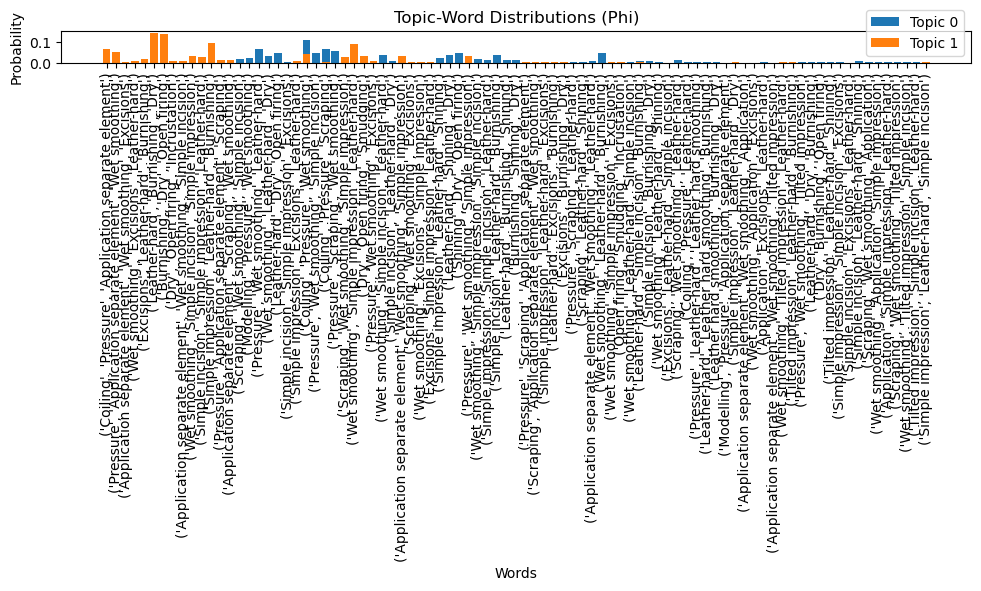

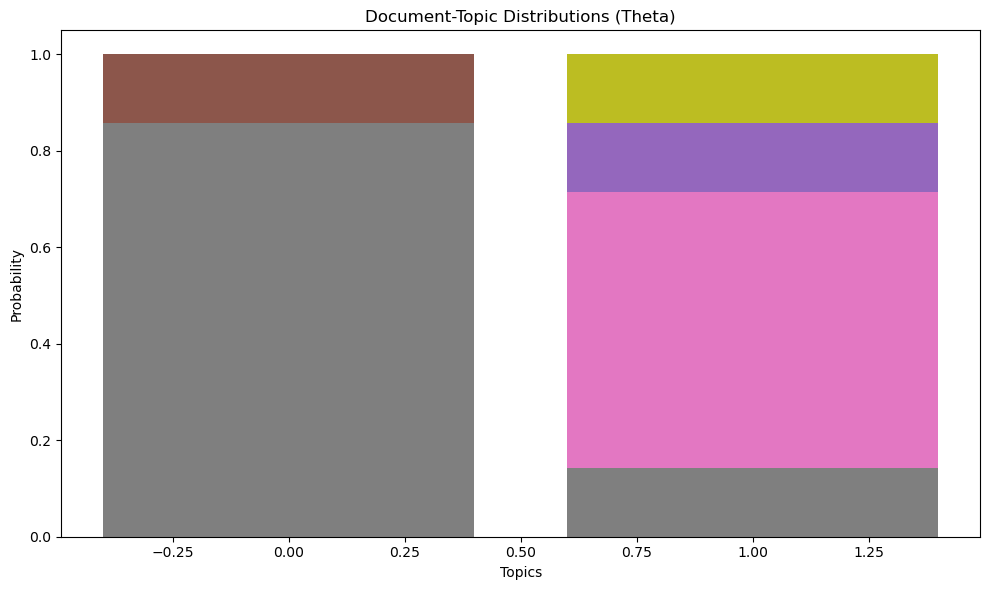

Documents mostly in Topic 1: [3, 8, 9, 12, 15, 19, 20, 22, 23, 24, 25, 30, 36, 39, 41, 42, 45, 47, 48, 49, 50, 51, 53, 56, 61, 68, 72, 73, 74, 75, 76, 83, 85, 89, 92, 93, 95, 99, 104, 105, 106, 107, 113, 118, 119, 120, 122, 125, 126, 128, 130, 131, 135, 136, 137, 140, 142, 143, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 168, 169, 170, 171, 172, 173, 174, 175, 177, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 192, 193, 195, 197]
Documents mostly in Topic 2: [0, 1, 2, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, 18, 21, 26, 27, 28, 29, 31, 32, 33, 34, 35, 37, 38, 40, 43, 44, 46, 52, 54, 55, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 69, 70, 71, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 90, 91, 94, 96, 97, 98, 100, 101, 102, 103, 108, 109, 110, 111, 112, 114, 115, 116, 117, 121, 123, 124, 127, 129, 132, 133, 134, 138, 139, 141, 144, 147, 153, 158, 166, 167, 176, 178, 180, 190, 191, 194, 196]


In [ ]:
# plot phi as bar plot 
import matplotlib.pyplot as plt

# Plot the topic-word distributions (phi)
def plot_phi(phi, vocab):
    plt.figure(figsize=(10, 6))
    for k in range(phi.shape[0]):
        plt.bar(range(len(vocab)), phi[k], label=f"Topic {k}")
    plt.xticks(ticks=range(len(vocab)), labels=vocab, rotation=90)
    plt.xlabel("Words")
    plt.ylabel("Probability")
    plt.title("Topic-Word Distributions (Phi)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_phi(phi, id2token)

In [11]:
def plot_technique_probability_comparison(vectorizer, X, labels, culture_names, lda=None, top_n=25):
    """
    Compare technique probabilities between cultures and optionally with LDA topics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    print(f"Features: {feature_names}")

    
    # Convert sparse matrix to dense if needed
    if not isinstance(X, np.ndarray):
        X_dense = X.toarray()
    else:
        X_dense = X
    
    # Calculate Empirical Probabilities for each culture 
    culture_probs = {}
    for culture in culture_names:
        mask = np.array(labels) == culture
        culture_counts = X_dense[mask].sum(axis=0)
        if culture_counts.sum() > 0:
            culture_probs[culture] = culture_counts / culture_counts.sum()
        else:
            culture_probs[culture] = np.zeros_like(feature_names, dtype=float)
    
    print(f"Culture probabilities: {culture_probs}")

    # Topic-Word Probabilities from LDA model
    topic_probs = {}
    if lda is not None:
        topic_word_dist = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
        for i in range(lda.n_components):
            topic_probs[f'Topic {i}'] = topic_word_dist[i]

    #  Create DataFrame for analysis 
    all_data = {**culture_probs, **topic_probs}
    df = pd.DataFrame(all_data, index=feature_names)
    
    # Find top differentiating techniques between the first two cultures 
    if len(culture_names) >= 2:
        df['abs_diff'] = np.abs(df[culture_names[0]] - df[culture_names[1]])
        top_diff = df.nlargest(top_n, 'abs_diff')
    else:
        # If only one culture, just show top techniques for that culture
        top_diff = df.nlargest(top_n, culture_names[0])

    plot_labels = list(culture_probs.keys()) + list(topic_probs.keys())
    num_bars = len(plot_labels)
    
    fig, ax = plt.subplots(figsize=(12, max(8, top_n * 0.4)))
    y_pos = np.arange(len(top_diff))
    bar_width = 0.8 / num_bars
    
    
    all_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Culture colors
    for i, label in enumerate(plot_labels):
        offset = (i - num_bars / 2 + 0.5) * bar_width
        ax.barh(y_pos + offset, top_diff[label], height=bar_width, 
                label=label, color=all_colors[i % len(all_colors)], alpha=0.8)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_diff.index)
    ax.invert_yaxis()
    ax.legend()
    ax.set_title('Top Differentiating Techniques: Empirical vs. LDA Topics')
    ax.set_xlabel('Probability')
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    return fig, df




198 documents after filtering
Document-term matrix shape: <Compressed Sparse Row sparse matrix of dtype 'int64'
	with 1299 stored elements and shape (198, 87)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (1, 0)	1
  (1, 1)	1
  (1, 5)	1
  (1, 6)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  (2, 0)	1
  (2, 5)	1
  (2, 6)	1
  (2, 9)	1
  (2, 10)	1
  (2, 11)	1
  (2, 12)	1
  (2, 13)	1
  (2, 14)	1
  :	:
  (194, 6)	1
  (194, 20)	1
  (194, 21)	1
  (194, 38)	1
  (194, 53)	1
  (195, 21)	1
  (195, 22)	1
  (195, 29)	1
  (195, 36)	1
  (195, 37)	1
  (195, 79)	1
  (196, 6)	1
  (196, 21)	1
  (196, 26)	1
  (196, 38)	1
  (196, 56)	1
  (196, 57)	1
  (196, 86)	1
  (197, 21)	1
  (197, 26)	1
  (197, 27)	1
  (197, 35)	1
  (197, 36)	1
  (197, 37)	1
  (197, 38)	1
Features: ["('Coiling', 'Pressure', 'Application separate element')"
 "('Pressure', 'Application separate element', 'Wet smoothing')"
 "('Application separate element', 'Wet smoothing', 'E

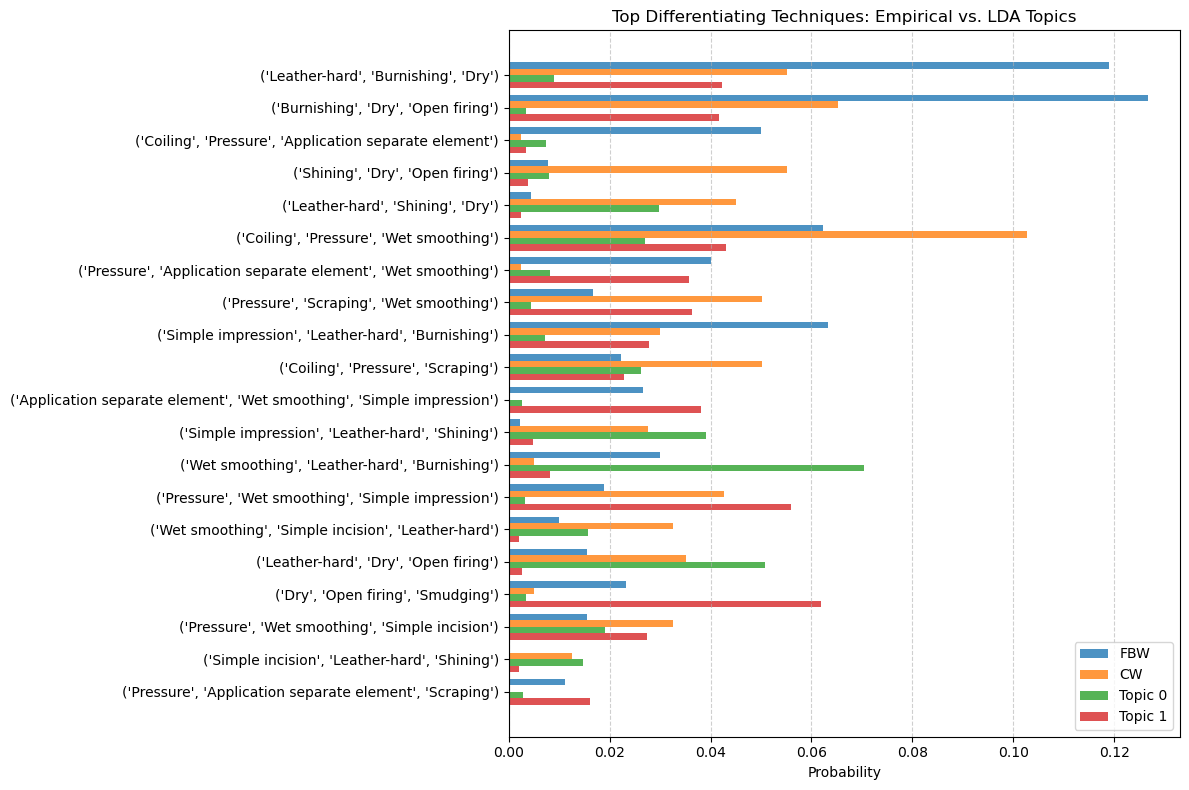

Comparison of Technique Probabilities:
                                                         FBW        CW  \
('Coiling', 'Pressure', 'Application separate e...  0.050000  0.002506   
('Pressure', 'Application separate element', 'W...  0.040000  0.002506   
('Application separate element', 'Wet smoothing...  0.003333  0.000000   
('Wet smoothing', 'Excisions', 'Leather-hard')      0.007778  0.000000   
('Excisions', 'Leather-hard', 'Burnishing')         0.012222  0.005013   

                                                     Topic 0   Topic 1  \
('Coiling', 'Pressure', 'Application separate e...  0.007395  0.003538   
('Pressure', 'Application separate element', 'W...  0.008190  0.035710   
('Application separate element', 'Wet smoothing...  0.003341  0.042981   
('Wet smoothing', 'Excisions', 'Leather-hard')      0.003136  0.009229   
('Excisions', 'Leather-hard', 'Burnishing')         0.019528  0.005519   

                                                    abs_diff  
('Coilin

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# dummy matrix  for plotting
vectorizer = CountVectorizer(
    vocabulary=token2id,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x
)
print(len(filtered_docs), "documents after filtering")

# Create the document-term matrix X from integer-encoded documents
X = vectorizer.transform(filtered_docs)

print(f"Document-term matrix shape: {X}")

# Labels for each document ('FBW' or 'CW') for empirical comparison 
# Determine the number of documents from each original file.
culture_names = ['FBW', 'CW']
labels = ['FBW'] * len(data_FBW[:135]) + ['CW'] * len(data_CW[:63])

# Now, ensure the labels list has the same length as the filtered documents matrix.
if len(labels) != X.shape[0]:
    print(f"Warning: Label count ({len(labels)}) does not match document count ({X.shape[0]}).")
    

# The plotting function expects an object with .components_ and .n_components attributes.
class MockLDA:
    def __init__(self, topic_word_counts, num_topics):
        # The function expects raw counts, not probabilities, for .components_
        self.components_ = topic_word_counts
        self.n_components = num_topics

# Use the 'nkw' phi counts from Gibbs sampler
mock_lda_model = MockLDA(phi, NUM_TOPICS)


fig, df_comparison = plot_technique_probability_comparison(
    vectorizer=vectorizer,
    X=X,
    labels=labels,
    culture_names=culture_names,
    lda=mock_lda_model,
    top_n=20  
)

plt.show()

print("Comparison of Technique Probabilities:")
print(df_comparison.head())

In [38]:
from collections import Counter
from scipy.spatial.distance import jensenshannon
import pandas as pd
import numpy as np

# words/ total words
num_fbw_docs = len(train_docs_FBW) # Number of FBW docs in the training set
fbw_docs_filtered = [doc for doc in filtered_docs[:num_fbw_docs] if doc]
cw_docs_filtered = [doc for doc in filtered_docs[num_fbw_docs:] if doc]

# Count token frequencies for each culture
fbw_counts = Counter(token for doc in fbw_docs_filtered for token in doc)
cw_counts = Counter(token for doc in cw_docs_filtered for token in doc)

# Combine into a single DataFrame
empirical_df = pd.DataFrame({'FBW': fbw_counts, 'CW': cw_counts}).fillna(0)

# Normalize counts to get empirical probability distributions P(word | culture)
empirical_prob_df = empirical_df / empirical_df.sum(axis=0)

print("Empirical Technique Probabilities per Culture:")
print(empirical_prob_df.head())


# Format the LDA topics (phi) from your model
# The phi matrix is (num_topics, vocab_size)
topic_prob_df = pd.DataFrame(nkw.T, index=id2token, columns=[f'Topic_{k}' for k in range(NUM_TOPICS)])

print("\n Model Topic-Word Probabilities ")
print(topic_prob_df.head())


# Calculate Jensen-Shannon Distance between topic and empirical distributions to see if topics can be associated with culture
combined_df = empirical_prob_df.join(topic_prob_df, how='outer').fillna(0)

distances = {}
cultures = ['FBW', 'CW']
topics = [f'Topic_{k}' for k in range(NUM_TOPICS)]

for culture in cultures:
    for topic in topics:
        # Get the probability vectors
        P = combined_df[culture].values
        Q = combined_df[topic].values
        
        # Calculate Jensen-Shannon distance
        jsd = jensenshannon(P, Q, base=2)
        distances[(culture, topic)] = jsd

dist_matrix = pd.Series(distances).unstack()
dist_matrix.index.name = "Culture"
dist_matrix.columns.name = "Model Topic"

print("\nJensen-Shannon Distance Matrix (Lower is Better):")
print(dist_matrix)

# Find the best matching topic for each culture
best_matches = dist_matrix.idxmin(axis=1)
print("\nBest Topic Match for Each Culture:")
for culture, topic in best_matches.items():
    print(f"Culture {culture} is best matched with {topic}, Jensen-Shannon Distance: {distances[(culture, topic)]:.4f}")

Empirical Technique Probabilities per Culture:
                                                         FBW        CW
('Coiling', 'Pressure', 'Application separate e...  0.050000  0.002506
('Pressure', 'Application separate element', 'W...  0.040000  0.002506
('Application separate element', 'Wet smoothing...  0.003333  0.000000
('Wet smoothing', 'Excisions', 'Leather-hard')      0.007778  0.000000
('Excisions', 'Leather-hard', 'Burnishing')         0.012222  0.005013

 Model Topic-Word Probabilities 
                                                    Topic_0  Topic_1
('Coiling', 'Pressure', 'Application separate e...      0.0     46.0
('Pressure', 'Application separate element', 'W...      0.0     37.0
('Application separate element', 'Wet smoothing...      0.0      3.0
('Wet smoothing', 'Excisions', 'Leather-hard')          0.0      7.0
('Excisions', 'Leather-hard', 'Burnishing')             0.0     13.0

Jensen-Shannon Distance Matrix (Lower is Better):
Model Topic   Topic_0   Topi

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
# Visualize the topics with pyLDAavis (common library online)
pyLDAvis.enable_notebook()

# Document-topic distributions (theta)
# Normalize the document-topic counts (ndk)
theta = (ndk + ALPHA) / (ndk.sum(axis=1, keepdims=True) + NUM_TOPICS * ALPHA)

# Document lengths
doc_lengths = [len(d) for d in docs_as_ids]

# Term frequency
# Sum the word counts for each term across all topics
term_frequency = nkw.sum(axis=0)

# Vocabulary
vocab = id2token

# pyLDAvis visualization
# Use the general pyLDAvis.prepare function
pyLDAvis.enable_notebook()
visualization = pyLDAvis.prepare(
    topic_term_dists=phi,
    doc_topic_dists=theta,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)

visualization

/Users/sasha/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/sasha/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/sasha/miniconda3/envs/tensorflow_env/lib/python3.11/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.242527  0.0       1        1  54.43341
0     -0.242527  0.0       2        1  45.56659, topic_info=                                                 Term       Freq       Total  \
11  ('Simple impression', 'Leather-hard', 'Burnish...  68.000000   68.000000   
26  ('Wet smoothing', 'Simple impression', 'Leathe...  66.000000   66.000000   
16      ('Pressure', 'Wet smoothing', 'Leather-hard')  41.000000   41.000000   
0   ('Coiling', 'Pressure', 'Application separate ...  45.000000   45.000000   
24          ('Pressure', 'Scraping', 'Wet smoothing')  35.000000   35.000000   
..                                                ...        ...         ...   
51  ('Application separate element', 'Wet smoothin...   4.026599    5.021099   
6                ('Burnishing', 'Dry', 'Open firing')  40.265987  139.716056   
56  ('Leather-hard', 'Simple incision', 'Burnishing')   4.026599    6.015600   
5               ('Leather-hard', 'Burnishing', 'Dry')  26.172891  128.606463   
38  ('Pressure', 'Wet smoothing', 'Simple impressi...   9.059847   33.922364   

   Category  logprob  loglift  
11  Default  30.0000  30.0000  
26  Default  29.0000  29.0000  
16  Default  28.0000  28.0000  
0   Default  27.0000  27.0000  
24  Default  26.0000  26.0000  
..      ...      ...      ...  
51   Topic2  -4.9904   0.5653  
6    Topic2  -2.6878  -0.4581  
56   Topic2  -4.9904   0.3846  
5    Topic2  -3.1186  -0.8060  
38   Topic2  -4.1795  -0.5342  

[117 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
13        1  1.005530  ('Application separate element', 'Scraping', '...
67        1  1.005530  ('Application separate element', 'Wet smoothin...
2         1  1.005530  ('Application separate element', 'Wet smoothin...
51        1  0.199160  ('Application separate element', 'Wet smoothin...
51        2  0.796638  ('Application separate element', 'Wet smoothin...
...     ...       ...                                                ...
39        2  0.993394  ('Wet smoothing', 'Simple impression', 'Simple...
29        2  0.993394  ('Wet smoothing', 'Simple incision', 'Leather-...
9         1  1.005530  ('Wet smoothing', 'Simple incision', 'Simple i...
71        1  1.005530  ('Wet smoothing', 'Tilted impression', 'Leathe...
84        2  0.993394  ('Wet smoothing', 'Tilted impression', 'Simple...

[95 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
def infer_new_doc_topics(new_doc_ids, phi, num_topics, alpha, iter=100):
    num_words_in_doc = len(new_doc_ids)

    #Randomly initialize topic assignments for the new document
    z_new = np.random.randint(0, num_topics, size=num_words_in_doc)

    # Count topic assignments for this document
    nd_new = np.zeros(num_topics)
    for k in range(num_topics):
        nd_new[k] = np.sum(z_new == k)

    topic_list = list(range(num_topics))

    # Gibbs sampling for P(t|w)
    for _ in range(iter):
        for i in range(num_words_in_doc):
            word_id = new_doc_ids[i]
            old_topic = z_new[i]
            nd_new[old_topic] -= 1

            # Calculate posterior probability for each topic
            p_z = (nd_new + alpha) * phi[:, word_id]

            # Sample new topic
            if np.sum(p_z) > 0:
                new_topic = np.random.choice(topic_list, p=p_z / np.sum(p_z))
            else:
                new_topic = np.random.choice(topic_list)

            z_new[i] = new_topic
            nd_new[new_topic] += 1

    # Normalize the final topic counts to get the percentage distribution
    topic_distribution = (nd_new + alpha) / (num_words_in_doc + num_topics * alpha)
    return topic_distribution



# New sample document representing a new vessel chaine-operatoire

new_sample_doc = [
    "('Wet clay', 'Modelling', 'Coiling')", 
    "('Modelling', 'Coiling', 'Pressure')",
    "('Coiling', 'Pressure', 'Wet smoothing')",
    "('Pressure', 'Wet smoothing', 'Simple impression')",
    "('Wet smoothing', 'Simple impression', 'Leather-hard')",
    "('Simple impression', 'Leather-hard', 'Burnishing')",
    "('Leather-hard', 'Burnishing', 'Dry')",
    "('Burnishing', 'Dry', 'Open firing')"
] # New sample from FBW

# new_sample_doc = [ "('Wet clay', 'Modelling', 'Coiling')", 
#     "('Modelling', 'Coiling', 'Pressure')",
#     "('Coiling', 'Pressure', 'Scraping')",
#     "('Pressure', 'Scraping', 'Wet smoothing')",
#     "('Scraping', 'Wet smoothing', 'Tilted impression')",
#     "('Wet smoothing', 'Tilted impression', 'Simple incision')",
#     "('Tilted impression', 'Simple incision', 'Leather-hard')",
#     "('Simple incision', 'Leather-hard', 'Dry')",
#     "('Leather-hard', 'Dry', 'Open firing')"
# ] # New sample from CW

# new_sample_doc = [
#     "('Wet clay', 'Modelling', 'Coiling')", 
#     "('Modelling', 'Coiling', 'Pressure')",
#     "('Coiling', 'Pressure', 'Wet smoothing')",
#     "('Pressure', 'Wet smoothing', 'Simple impression')",
#     "('Wet smoothing', 'Tilted impression', 'Simple incision')",
#     "('Tilted impression', 'Simple incision', 'Leather-hard')",
#     "('Simple incision', 'Leather-hard', 'Dry')",
#     "('Leather-hard', 'Dry', 'Open firing')"
# ] # New sample with mixed techniques

# new_sample_doc = [ "('Wet clay', 'Modelling', 'Coiling')", 
#     "('Modelling', 'Coiling', 'Pressure')",
#     "('Coiling', 'Pressure', 'Scraping')",
#     "('Pressure', 'Scraping', 'Wet smoothing')",
#     "('Wet smoothing', 'Simple impression', 'Leather-hard')",
#     "('Simple impression', 'Leather-hard', 'Burnishing')",
#     "('Leather-hard', 'Burnishing', 'Dry')",
#     "('Burnishing', 'Dry', 'Open firing')"
# ] # New sample with mixed techniques more of FBW and less of CW

# one from test_docs
print(f"Number of test documents: {len(test_docs)}")
new_sample_doc = test_docs[np.random.randint(len(test_docs))]
# Pre-process the new sample
new_sample_ids = [token2id[token] for token in new_sample_doc if token in token2id]

if not new_sample_ids:
    print("The new sample contains no known techniques from the vocabulary.")
else:
    # Infer the topic distribution
    new_topic_dist = infer_new_doc_topics(new_sample_ids, phi, NUM_TOPICS, ALPHA)

    # 4. Print the results
    print("New Sample Document:", new_sample_doc)
    print("\nTopic Percentages for the New Sample:")
    for k in range(NUM_TOPICS):
        print(f"  Topic {k}: {new_topic_dist[k]:.2%}")

Number of test documents: 76
New Sample Document: ["('Wet clay', 'Modelling', 'Coiling')", "('Modelling', 'Coiling', 'Pressure')", "('Coiling', 'Pressure', 'Scraping')", "('Pressure', 'Scraping', 'Wet smoothing')", "('Scraping', 'Wet smoothing', 'Simple incision')", "('Wet smoothing', 'Simple incision', 'Simple impression')", "('Simple incision', 'Simple impression', 'Leather-hard')", "('Simple impression', 'Leather-hard', 'Shining')", "('Leather-hard', 'Shining', 'Dry')", "('Shining', 'Dry', 'Open firing')"]

Topic Percentages for the New Sample:
  Topic 0: 60.00%
  Topic 1: 40.00%


In [16]:
# calculate the kullback leiber divergence between the topics distribution
import scipy.stats as stats
def kullback_leibler_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two probability distributions.
    Adds a small epsilon to avoid division by zero.
    """
    epsilon = 1e-10
    p_smooth = p + epsilon
    q_smooth = q + epsilon
    
    return np.sum(p_smooth * np.log(p_smooth / q_smooth))

print("Kullback-Leibler Divergence between Topic 0 and Topic 1:")
# Calculate KL divergence in both directions as it's not symmetric
kl_div_01 = kullback_leibler_divergence(phi[0], phi[1])
kl_div_10 = kullback_leibler_divergence(phi[1], phi[0])

print(f"D_KL(Topic 0 || Topic 1): {kl_div_01:.4f}")
print(f"D_KL(Topic 1 || Topic 0): {kl_div_10:.4f}")

Kullback-Leibler Divergence between Topic 0 and Topic 1:
D_KL(Topic 0 || Topic 1): 12.2358
D_KL(Topic 1 || Topic 0): 8.4709


In [ ]:
# perplexity with new data (Low...) Predictive for the culture but not in terms of likelihood 

def calculate_perplexity_manual(test_docs_ids, phi, alpha, num_topics, infer_iterations=100):
    total_log_likelihood = 0
    total_word_count = 0

    for doc_ids in test_docs_ids:
        if not doc_ids:
            continue
        # For each test doc, infer its topic distribution using the trained model (phi)
        # We use your existing inference function for this
        theta_d = infer_new_doc_topics(doc_ids, phi, num_topics, alpha, iter=infer_iterations)

        doc_log_likelihood = 0
        for word_id in doc_ids:
            # Prob of word = sum over topics [P(word|topic) * P(topic|doc)]
            prob_word = np.dot(phi[:, word_id], theta_d)
            if prob_word > 0:
                doc_log_likelihood += np.log(prob_word)
        
        total_log_likelihood += doc_log_likelihood
        total_word_count += len(doc_ids)

    if total_word_count == 0:
        return float('inf')

    perplexity = np.exp(-total_log_likelihood / total_word_count)
    return perplexity

test_docs_filtered = [[token for token in doc if token not in custom_tokens] for doc in test_docs]
test_docs_ids = [[token2id[token] for token in doc if token in token2id] for doc in test_docs_filtered]
test_docs_ids = [doc for doc in test_docs_ids if doc]
perplexity_manual = calculate_perplexity_manual(test_docs_ids, phi, ALPHA, NUM_TOPICS)
print(f"\nManual Model Perplexity: {perplexity_manual:.4f}")


Calculating perplexity on 76 test documents...
Processing document with 8 words.
Processing document with 4 words.
Processing document with 5 words.
Processing document with 8 words.
Processing document with 6 words.
Processing document with 5 words.
Processing document with 6 words.
Processing document with 7 words.
Processing document with 5 words.
Processing document with 5 words.
Processing document with 5 words.
Processing document with 5 words.
Processing document with 5 words.
Processing document with 6 words.
Processing document with 8 words.
Processing document with 7 words.
Processing document with 7 words.
Processing document with 8 words.
Processing document with 6 words.
Processing document with 6 words.
Processing document with 7 words.
Processing document with 7 words.
Processing document with 6 words.
Processing document with 7 words.
Processing document with 4 words.
Processing document with 6 words.
Processing document with 5 words.
Processing document with 7 words.
P

In [ ]:
from itertools import combinations

def calculate_coherence_cv_manual(docs_as_tokens, phi, id2token, top_n=10):

    doc_word_sets = [set(doc) for doc in docs_as_tokens]
    
    word_doc_counts = {}
    for doc_set in doc_word_sets:
        for word in doc_set:
            word_doc_counts[word] = word_doc_counts.get(word, 0) + 1

    co_occurrence_counts = {}
    for doc_set in doc_word_sets:
        for w1, w2 in combinations(doc_set, 2):
            pair = tuple(sorted((w1, w2)))
            co_occurrence_counts[pair] = co_occurrence_counts.get(pair, 0) + 1
            
    num_docs = len(docs_as_tokens)
    topic_coherences = []
    
    for k in range(phi.shape[0]):
        # Get top N words for the topic
        top_word_ids = np.argsort(phi[k])[-top_n:]
        top_words = [id2token[word_id] for word_id in top_word_ids]
        
        topic_npmi_scores = []
        for w1, w2 in combinations(top_words, 2):
            pair = tuple(sorted((w1, w2)))
            
            # P(w1, w2)
            p_w1_w2 = (co_occurrence_counts.get(pair, 0) + 1e-9) / num_docs
            # P(w1) * P(w2)
            p_w1_p_w2 = ((word_doc_counts.get(w1, 0) + 1e-9) / num_docs) * \
                        ((word_doc_counts.get(w2, 0) + 1e-9) / num_docs)
            
            if p_w1_p_w2 > 0 and p_w1_w2 > 0:
                npmi = np.log(p_w1_w2 / p_w1_p_w2) / -np.log(p_w1_w2)
                topic_npmi_scores.append(npmi)
        
        if topic_npmi_scores:
            topic_coherences.append(np.mean(topic_npmi_scores))

    return np.mean(topic_coherences) if topic_coherences else 0.0

# Coherence C_v ,here very bad :( 
coherence_manual = calculate_coherence_cv_manual(filtered_docs, phi, id2token, top_n=10)
print(f"\nManual Model Coherence (C_v): {coherence_manual:.4f}")

Calculating coherence using 198 documents for context...

Manual Model Coherence (C_v): -0.0624


# Let's repeat the analysis with Gensim (dedicated library for NLP) 

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from gensim import corpora, models
from gensim.corpora.dictionary import Dictionary
custom_tokens = {
    "('Wet clay', 'Modelling', 'Coiling')",
    "('Wet clay', 'Coiling', 'Pressure')",
    "('Wet clay', 'Modelling', 'Pressure')",
    "('Modelling', 'Coiling', 'Pressure')"
}
# note that the tokens are 3 techniques set
gensim_docs = [[token for token in doc if token not in custom_tokens] for doc in filtered_docs]
gensim_docs = [doc for doc in gensim_docs if doc]
# Build dictionary
dictionary = corpora.Dictionary(gensim_docs)
print(f"Dictionary size: {len(dictionary)}")
print(f"Sample tokens in dictionary: {[dictionary[i] for i in range(min(5, len(dictionary)))]}")

# Bag-of-words representation assumption in the corpus
corpus = [dictionary.doc2bow(doc) for doc in gensim_docs]

# model with weights on frequency of terms across documents
tfidf_model = models.TfidfModel(corpus)

# TF-IDF transformation (add weights to words based on occurrences between documents)
corpus_tfidf = tfidf_model[corpus]

# using corpus_tfidf 
lda_model = models.LdaModel(
    corpus_tfidf,
    num_topics=2,
    id2word=dictionary,
    passes=20,
    random_state=42,
    per_word_topics=True,
    alpha='auto',
    eta='auto',
)
print(lda_model.alpha, lda_model.eta)

doc_id = 0
for word_id, weight in corpus_tfidf[doc_id]:
    print(f"Token: {dictionary[word_id]}  |  TF–IDF weight: {weight:.4f}")


Dictionary size: 87
Sample tokens in dictionary: ["('Application separate element', 'Wet smoothing', 'Excisions')", "('Burnishing', 'Dry', 'Open firing')", "('Coiling', 'Pressure', 'Application separate element')", "('Dry', 'Open firing', 'Incrustation')", "('Excisions', 'Leather-hard', 'Burnishing')"]
[1.506795  2.1317759] [0.6227764  1.5148951  1.0333697  0.6130324  1.0169713  1.7012923
 1.0463449  0.65190756 0.7361114  1.033476   1.2258797  1.3401728
 0.67383367 0.6694989  1.1881195  1.3749408  0.83341146 1.7474513
 1.0972606  0.6331704  0.5453746  2.7134316  1.9509482  2.0544777
 1.1613144  1.988719   1.0722804  1.180026   0.6117053  0.6030531
 1.8010998  0.86159724 0.66384095 0.8368808  0.5496603  1.2447457
 0.7992251  0.66785836 1.0773485  0.6638559  0.66832656 0.6802811
 1.0907431  0.6852351  0.6013974  0.5958449  0.55476266 0.54956025
 0.5579524  0.42819715 0.42851186 0.7508107  2.079562   0.534532
 0.55736065 0.5959483  0.60214496 0.5255704  0.50773567 0.4196237
 1.0416512  0.

In [39]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus_tfidf]

[(0, '0.085*"(\'Pressure\', \'Wet smoothing\', \'Leather-hard\')" + 0.070*"(\'Wet smoothing\', \'Leather-hard\', \'Burnishing\')" + 0.055*"(\'Leather-hard\', \'Dry\', \'Open firing\')" + 0.051*"(\'Wet smoothing\', \'Leather-hard\', \'Dry\')" + 0.040*"(\'Modelling\', \'Pressure\', \'Wet smoothing\')" + 0.039*"(\'Shining\', \'Dry\', \'Open firing\')" + 0.038*"(\'Leather-hard\', \'Shining\', \'Dry\')" + 0.030*"(\'Wet smoothing\', \'Simple incision\', \'Leather-hard\')" + 0.030*"(\'Simple impression\', \'Leather-hard\', \'Shining\')" + 0.027*"(\'Coiling\', \'Pressure\', \'Wet smoothing\')"'), (1, '0.063*"(\'Simple impression\', \'Leather-hard\', \'Burnishing\')" + 0.062*"(\'Wet smoothing\', \'Simple impression\', \'Leather-hard\')" + 0.056*"(\'Pressure\', \'Wet smoothing\', \'Simple impression\')" + 0.043*"(\'Coiling\', \'Pressure\', \'Wet smoothing\')" + 0.043*"(\'Coiling\', \'Pressure\', \'Application separate element\')" + 0.042*"(\'Leather-hard\', \'Burnishing\', \'Dry\')" + 0.042*"(\'

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.
# Compute Coherence Score circa 0.7 nice, around 0.4/5 there is something to review
coherence_model_lda = CoherenceModel(model=lda_model, texts=gensim_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.357440836151421

Coherence Score:  0.38186257617876485


T=2 | BoW coh=0.371, perp=-4.42 | TFIDF coh=0.469, perp=-4.55
T=3 | BoW coh=0.412, perp=-4.60 | TFIDF coh=0.459, perp=-4.75
T=4 | BoW coh=0.410, perp=-4.79 | TFIDF coh=0.451, perp=-4.91
T=5 | BoW coh=0.431, perp=-4.87 | TFIDF coh=0.462, perp=-5.03
T=6 | BoW coh=0.401, perp=-4.95 | TFIDF coh=0.454, perp=-5.08


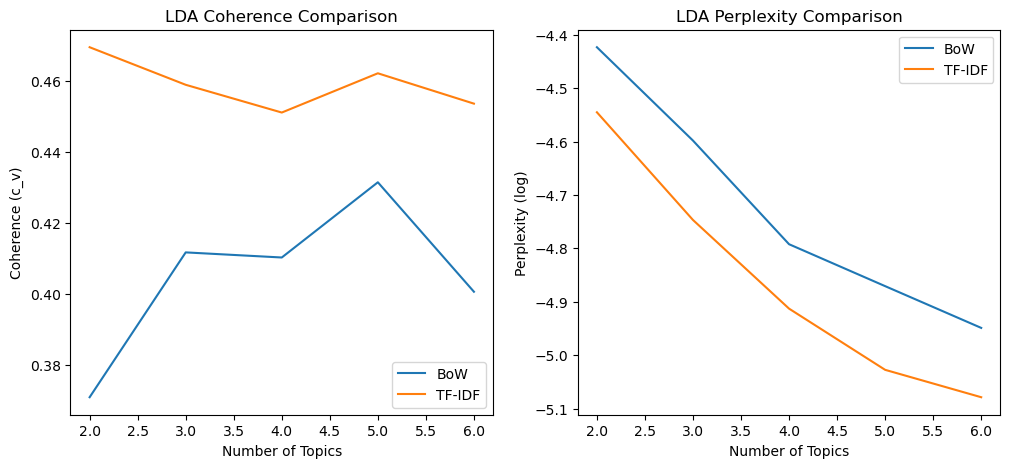

In [ ]:
# this cell is to compare weighted model TF-IDF with normal LDA
def evaluate_lda_models(documents, dictionary, corpus, start=2, limit=6, step=1):
    """
    Train LDA with BoW and TF-IDF, compare coherence & perplexity.
    """
    results = {"bow": {"coherence": [], "perplexity": []},
               "tfidf": {"coherence": [], "perplexity": []}}
    
    tfidf_model = models.TfidfModel(corpus)
    corpus_tfidf = tfidf_model[corpus]
    
    for num_topics in range(start, limit+1, step):
        lda_bow = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=20
        )
        coherence_bow = CoherenceModel(
            model=lda_bow,
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        perplexity_bow = lda_bow.log_perplexity(corpus)
        
        results["bow"]["coherence"].append(coherence_bow)
        results["bow"]["perplexity"].append(perplexity_bow)
        
        lda_tfidf = models.LdaModel(
            corpus=corpus_tfidf,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=20
        )
        coherence_tfidf = CoherenceModel(
            model=lda_tfidf,
            texts=documents,
            dictionary=dictionary,
            coherence='c_v'
        ).get_coherence()
        perplexity_tfidf = lda_tfidf.log_perplexity(corpus_tfidf)
        
        results["tfidf"]["coherence"].append(coherence_tfidf)
        results["tfidf"]["perplexity"].append(perplexity_tfidf)
        
        print(f"T={num_topics} | BoW coh={coherence_bow:.3f}, perp={perplexity_bow:.2f} | "
              f"TFIDF coh={coherence_tfidf:.3f}, perp={perplexity_tfidf:.2f}")
    
    x = list(range(start, limit+1, step))
    plt.figure(figsize=(12,5))
    
    # Coherence
    plt.subplot(1,2,1)
    plt.plot(x, results["bow"]["coherence"], label="BoW")
    plt.plot(x, results["tfidf"]["coherence"], label="TF-IDF")
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence (c_v)")
    plt.title("LDA Coherence Comparison")
    plt.legend()
    
    # Perplexity
    plt.subplot(1,2,2)
    plt.plot(x, results["bow"]["perplexity"], label="BoW")
    plt.plot(x, results["tfidf"]["perplexity"], label="TF-IDF")
    plt.xlabel("Number of Topics")
    plt.ylabel("Perplexity (log)")
    plt.title("LDA Perplexity Comparison")
    plt.legend()
    
    plt.show()
    
    return results

results = evaluate_lda_models(gensim_docs, dictionary, corpus_tfidf, start=2, limit=6, step=1)

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.136497  0.0       1        1  59.889414
0     -0.136497  0.0       2        1  40.110586, topic_info=                                                 Term       Freq      Total  \
17      ('Pressure', 'Wet smoothing', 'Leather-hard')  16.000000  16.000000   
52    ('Wet smoothing', 'Leather-hard', 'Burnishing')  14.000000  14.000000   
15             ('Leather-hard', 'Dry', 'Open firing')  10.000000  10.000000   
18           ('Wet smoothing', 'Leather-hard', 'Dry')   9.000000   9.000000   
9   ('Simple impression', 'Leather-hard', 'Burnish...  17.000000  17.000000   
..                                                ...        ...        ...   
21           ('Coiling', 'Pressure', 'Wet smoothing')   4.818989  16.260638   
60      ('Scraping', 'Wet smoothing', 'Leather-hard')   2.161937   4.585148   
14   ('Scraping', 'Wet smoothing', 'Simple incision')   2.344332   5.458984   
22   ('Pressure', 'Wet smoothing', 'Simple incision')   3.406468  10.668250   
5               ('Leather-hard', 'Burnishing', 'Dry')   1.604648  12.825900   

   Category  logprob  loglift  
17  Default  30.0000  30.0000  
52  Default  29.0000  29.0000  
15  Default  28.0000  28.0000  
18  Default  27.0000  27.0000  
9   Default  26.0000  26.0000  
..      ...      ...      ...  
21   Topic2  -3.6089  -0.3027  
60   Topic2  -4.4104   0.1617  
14   Topic2  -4.3294   0.0683  
22   Topic2  -3.9558  -0.2281  
5    Topic2  -4.7085  -1.1650  

[106 rows x 6 columns], token_table=      Topic      Freq                                               Term
term                                                                    
12        1  0.834489  ('Application separate element', 'Scraping', '...
51        1  0.284762  ('Application separate element', 'Wet smoothin...
51        2  0.854286  ('Application separate element', 'Wet smoothin...
31        1  0.943274  ('Application separate element', 'Wet smoothin...
8         1  0.959376  ('Application separate element', 'Wet smoothin...
...     ...       ...                                                ...
11        1  0.803860  ('Wet smoothing', 'Simple incision', 'Simple i...
11        2  0.114837  ('Wet smoothing', 'Simple incision', 'Simple i...
72        1  0.479433  ('Wet smoothing', 'Tilted impression', 'Leathe...
72        2  0.958866  ('Wet smoothing', 'Tilted impression', 'Leathe...
85        2  0.612005  ('Wet smoothing', 'Tilted impression', 'Simple...

[123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [ ]:
# Get the word distribution for each topic
print("Word Distributions per Topic")
for topic_id in range(lda_model.num_topics):
    print(f"\nTopic {topic_id}:")
    # print_topic() shows the top N words and their probabilities
    topic_terms = lda_model.print_topic(topic_id, topn=5)
    print(topic_terms)

# Get the topic distribution for a specific document
print("\nTopic Distribution for a Sample Document")
# Let's inspect the first document in our corpus
doc_id = 0
# The model expects the document in bag-of-words format
bow_doc = corpus[doc_id] 
doc_topics = lda_model.get_document_topics(bow_doc)

print(f"Original Document (tokens): {gensim_docs[doc_id]}")
print(f"\nTopic distribution for Document {doc_id}:")
print(doc_topics)

--- Word Distributions per Topic ---

Topic 0:
0.085*"('Pressure', 'Wet smoothing', 'Leather-hard')" + 0.070*"('Wet smoothing', 'Leather-hard', 'Burnishing')" + 0.055*"('Leather-hard', 'Dry', 'Open firing')" + 0.051*"('Wet smoothing', 'Leather-hard', 'Dry')" + 0.040*"('Modelling', 'Pressure', 'Wet smoothing')"

Topic 1:
0.063*"('Simple impression', 'Leather-hard', 'Burnishing')" + 0.062*"('Wet smoothing', 'Simple impression', 'Leather-hard')" + 0.056*"('Pressure', 'Wet smoothing', 'Simple impression')" + 0.043*"('Coiling', 'Pressure', 'Wet smoothing')" + 0.043*"('Coiling', 'Pressure', 'Application separate element')"

--- Topic Distribution for a Sample Document ---
Original Document (tokens): ["('Coiling', 'Pressure', 'Application separate element')", "('Pressure', 'Application separate element', 'Wet smoothing')", "('Application separate element', 'Wet smoothing', 'Excisions')", "('Wet smoothing', 'Excisions', 'Leather-hard')", "('Excisions', 'Leather-hard', 'Burnishing')", "('Leathe

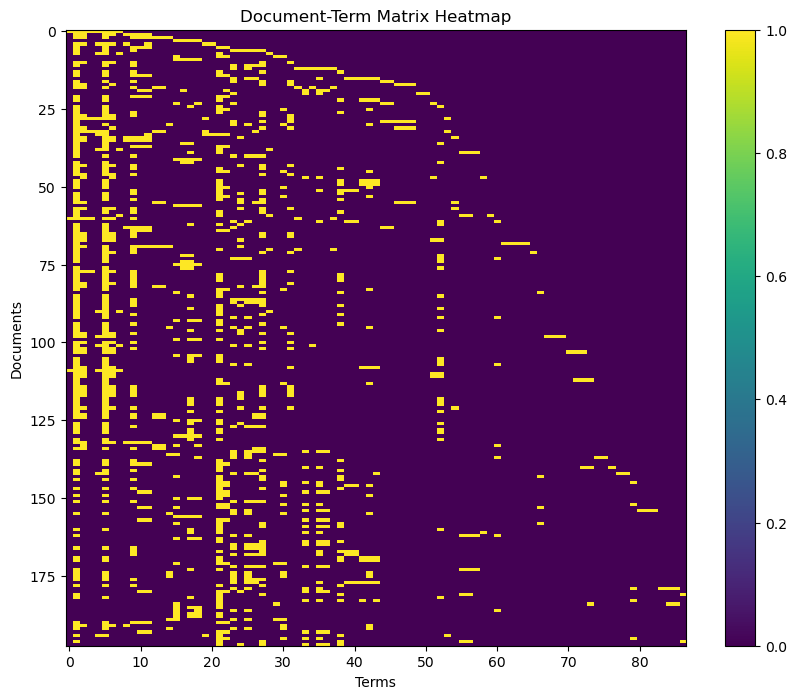

Features: ["('Application separate element', 'Wet smoothing', 'Excisions')"
 "('Burnishing', 'Dry', 'Open firing')"
 "('Coiling', 'Pressure', 'Application separate element')"
 "('Dry', 'Open firing', 'Incrustation')"
 "('Excisions', 'Leather-hard', 'Burnishing')"
 "('Leather-hard', 'Burnishing', 'Dry')"
 "('Pressure', 'Application separate element', 'Wet smoothing')"
 "('Wet smoothing', 'Excisions', 'Leather-hard')"
 "('Application separate element', 'Wet smoothing', 'Simple incision')"
 "('Simple impression', 'Leather-hard', 'Burnishing')"
 "('Simple incision', 'Simple impression', 'Leather-hard')"
 "('Wet smoothing', 'Simple incision', 'Simple impression')"
 "('Application separate element', 'Scraping', 'Wet smoothing')"
 "('Pressure', 'Application separate element', 'Scraping')"
 "('Scraping', 'Wet smoothing', 'Simple incision')"
 "('Leather-hard', 'Dry', 'Open firing')"
 "('Modelling', 'Pressure', 'Wet smoothing')"
 "('Pressure', 'Wet smoothing', 'Leather-hard')"
 "('Wet smoothing'

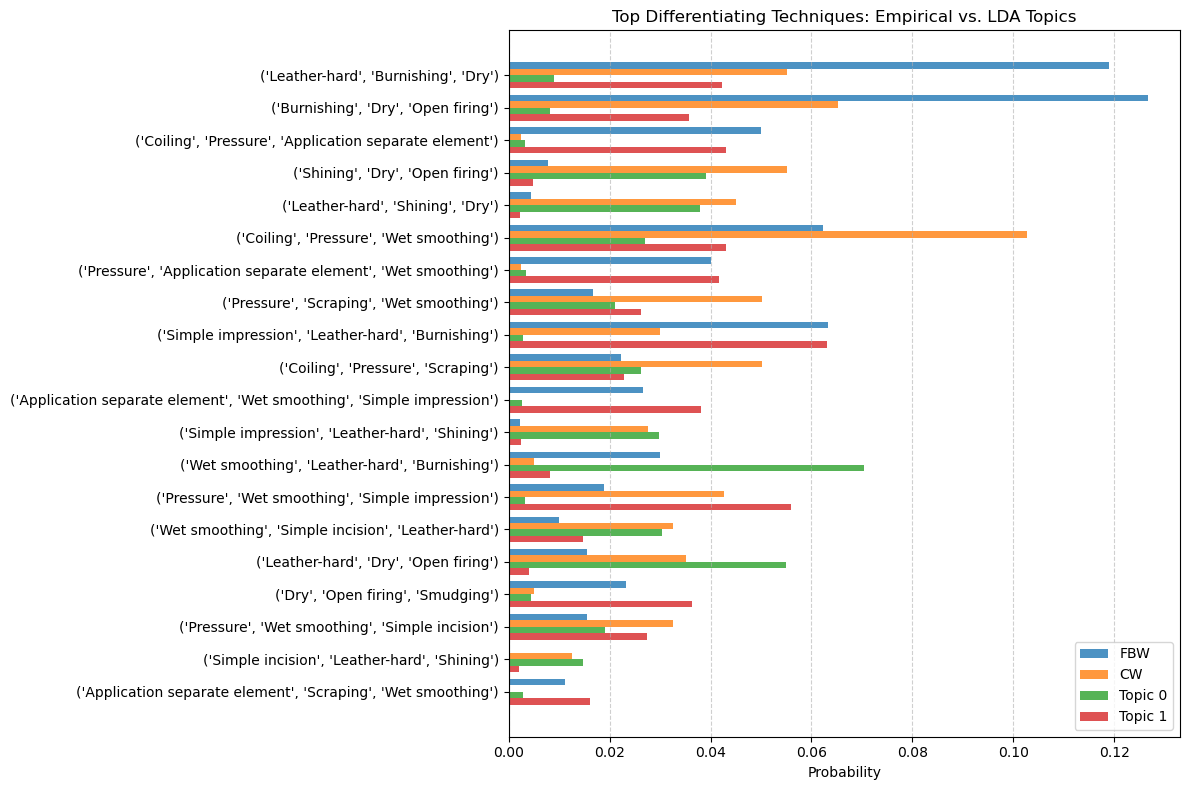

In [26]:
# ---. Compare Empirical Frequencies with LDA Topics ---

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# To create correct labels, we need to know how many docs from each culture survived the filtering
final_docs_FBW = [d for d in [[t for t in doc if t not in custom_tokens] for doc in docs_FBW] if d]
final_docs_CW = [d for d in [[t for t in doc if t not in custom_tokens] for doc in docs_CW] if d]
labels = ['FBW'] * len(train_docs_FBW) + ['CW'] * len(train_docs_CW)

# Use the vocabulary from the Gensim dictionary for consistency
vectorizer = CountVectorizer(
    vocabulary=dictionary.token2id,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x
)
final_docs = final_docs_FBW + final_docs_CW
# Use the final_docs from the Gensim pipeline to create the document-term matrix
X = vectorizer.transform(docs)
# heat map X
plt.figure(figsize=(10, 8))
plt.imshow(X.toarray(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Document-Term Matrix Heatmap")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

# The plotting function expects an object with a .components_ attribute.
# We can use the Gensim model's topic-word distribution.
class GensimLDAWrapper:
    def __init__(self, lda_model):
        self.components_ = lda_model.get_topics() # This gets the topic-word probability matrix
        self.n_components = lda_model.num_topics

# Wrap the trained Gensim model
gensim_lda_wrapped = GensimLDAWrapper(lda_model)

# Generate the comparison plot
fig, df_comparison = plot_technique_probability_comparison(
    vectorizer=vectorizer,
    X=X,
    labels=labels,
    culture_names=['FBW', 'CW'],
    lda=gensim_lda_wrapped,
    top_n=20  
)
plt.show()

In [ ]:
from collections import Counter
from scipy.spatial.distance import jensenshannon
import pandas as pd
import numpy as np

# We use the filtered documents to be consistent with the model's vocabulary
# First, separate the filtered documents back by their original culture
num_fbw_docs = len(train_docs_FBW) # Number of FBW docs in the training set
fbw_docs_filtered = [doc for doc in filtered_docs[:num_fbw_docs] if doc]
cw_docs_filtered = [doc for doc in filtered_docs[num_fbw_docs:] if doc]

# Count token frequencies for each culture
fbw_counts = Counter(token for doc in fbw_docs_filtered for token in doc)
cw_counts = Counter(token for doc in cw_docs_filtered for token in doc)

# Combine into a single DataFrame, which handles missing tokens automatically
empirical_df = pd.DataFrame({'FBW': fbw_counts, 'CW': cw_counts}).fillna(0)

# Normalize counts to get empirical probability distributions P(word | culture)
empirical_prob_df = empirical_df / empirical_df.sum(axis=0)

print(empirical_prob_df.head())


# The phiLDAmatrix is (num_topics, vocab_size)
phi = lda_model.get_topics()  # Get the topic-word distribution from Gensim LDA model

gensim_vocab = [dictionary[i] for i in range(len(dictionary))]
topic_prob_df = pd.DataFrame(phi.T, index=gensim_vocab, columns=[f'Topic_{k}' for k in range(NUM_TOPICS)])

print("\nModel Topic-Word Probabilities")
print(topic_prob_df.head())


# Align both dataframes by the vocabulary index to ensure order is identical
combined_df = empirical_prob_df.join(topic_prob_df, how='outer').fillna(0)

distances = {}
cultures = ['FBW', 'CW']
topics = [f'Topic_{k}' for k in range(NUM_TOPICS)]

for culture in cultures:
    for topic in topics:
        # Get the probability vectors
        P = combined_df[culture].values
        Q = combined_df[topic].values
        
        # Calculate Jensen-Shannon distance
        jsd = jensenshannon(P, Q, base=2)
        distances[(culture, topic)] = jsd

# --- 4. Display Results ---
dist_matrix = pd.Series(distances).unstack()
dist_matrix.index.name = "Culture"
dist_matrix.columns.name = "Model Topic"

print("\nJensen-Shannon Distance Matrix (Lower is Better)")
print(dist_matrix)

# Find the best matching topic for each culture
best_matches = dist_matrix.idxmin(axis=1)
print("\nBest Topic Match for Each Culture")
for culture, topic in best_matches.items():
    print(f"Culture {culture} is best matched with {topic}, Jensen-Shannon Distance: {distances[(culture, topic)]:.4f}")

--- Empirical Technique Probabilities per Culture ---
                                                         FBW        CW
('Coiling', 'Pressure', 'Application separate e...  0.050000  0.002506
('Pressure', 'Application separate element', 'W...  0.040000  0.002506
('Application separate element', 'Wet smoothing...  0.003333  0.000000
('Wet smoothing', 'Excisions', 'Leather-hard')      0.007778  0.000000
('Excisions', 'Leather-hard', 'Burnishing')         0.012222  0.005013

--- Model Topic-Word Probabilities ---
                                                     Topic_0   Topic_1
('Application separate element', 'Wet smoothing...  0.007395  0.003538
('Burnishing', 'Dry', 'Open firing')                0.008190  0.035710
('Coiling', 'Pressure', 'Application separate e...  0.003341  0.042981
('Dry', 'Open firing', 'Incrustation')              0.003136  0.009229
('Excisions', 'Leather-hard', 'Burnishing')         0.019528  0.005519

--- Jensen-Shannon Distance Matrix (Lower is Better) 

In [ ]:
# Define a new document (a new vessel's chaine-operatoire)
new_doc_text = [
    "('Wet clay', 'Modelling', 'Coiling')",
    "('Modelling', 'Coiling', 'Pressure')",
    "('Coiling', 'Pressure', 'Wet smoothing')",
    "('Pressure', 'Wet smoothing', 'Simple incision')",
    "('Wet smoothing', 'Simple incision', 'Simple impression')",
    "('Simple incision', 'Simple impression', 'Leather-hard')",
    "('Simple impression', 'Leather-hard', 'Burnishing')",
    "('Leather-hard', 'Burnishing', 'Dry')",
    "('Burnishing', 'Dry', 'Open firing')"
] # from FBW


new_doc_text = [
    "('Wet clay', 'Modelling', 'Coiling')",
    "('Modelling', 'Coiling', 'Pressure')",
    "('Coiling', 'Pressure', 'Scraping')",
    "('Pressure', 'Scraping', 'Wet smoothing')",
    "('Scraping', 'Wet smoothing', 'Simple incision')",
    "('Wet smoothing', 'Simple incision', 'Leather-hard')",
    "('Simple incision', 'Leather-hard', 'Burnishing')",
    "('Leather-hard', 'Burnishing', 'Dry')",
    "('Burnishing', 'Dry', 'Open firing')"
] # from CW

# The dictionary will ignore any words it hasn't seen before.
new_doc_bow = dictionary.doc2bow(new_doc_text)

# Infer the topic distribution for the new BoW vector
new_doc_topics = lda_model.get_document_topics(new_doc_bow)

print("New Document:", new_doc_text)
print("\nInferred Topic Percentages for the New Document:")
for topic_id, prob in new_doc_topics:
    print(f"  Topic {topic_id}: {prob:.4f}")

New Document: ["('Wet clay', 'Modelling', 'Coiling')", "('Modelling', 'Coiling', 'Pressure')", "('Coiling', 'Pressure', 'Scraping')", "('Pressure', 'Scraping', 'Wet smoothing')", "('Scraping', 'Wet smoothing', 'Simple incision')", "('Wet smoothing', 'Simple incision', 'Leather-hard')", "('Simple incision', 'Leather-hard', 'Burnishing')", "('Leather-hard', 'Burnishing', 'Dry')", "('Burnishing', 'Dry', 'Open firing')"]

Inferred Topic Percentages for the New Document:
  Topic 0: 0.5602
  Topic 1: 0.4398
